### Questions

- What we have implemented now is a particle filter with a brdige proposal. This is different from the methods in the paper, since they use an MCMC step to sample from the bridge. Can we do this in `pfjax` easily?
- What are the importance weights when e use the MCMC step?


In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pfjax as pf
import pfjax.sde as sde

## Model

The Jump-Diffusion model is the following:

$$
\begin{aligned}
Z_{t+\Delta t} &= Z_t + (\theta + \kappa Z_t) \Delta t + \sigma_z \sqrt{Z_t} \Delta W_t^z + V_{t+\Delta t}^z J_{t+\Delta t} \\
X_{t+\Delta t} &= X_t + \alpha \Delta t + \sqrt{Z_t} \Delta W_t^x + V_{t+\Delta t}^x J_{t+\Delta t} 
\end{aligned}
$$

where

$$
\begin{aligned}
\Delta W_t^x, \Delta W_t^z &\sim \textrm{iid } N(0, \Delta t) \\
V_t^z &\sim \exp(\mu_z) \\
V_t^x &\sim N(\mu_x, \sigma^2_x) \\
J_{t+\Delta t} &\sim \textrm{Bern}(\lambda \Delta t).
\end{aligned}
$$

Thus, our parameters are $\Theta = (\alpha, \theta, \kappa, \sigma_z, \lambda,\mu_x, \sigma_x, \mu_z)$, observation is $X_t$ (the logarithm of asset price), and latent state $Z_t$ (unobserved volatility).

In [2]:
def euler_sim_jump(key, x, dt, drift_diff, jump, theta):
    """
    Simulate SDE with dense diffusion using Euler-Maruyama discretization.
    Args:
        key: PRNG key.
        x: Initial value of the SDE.  A vector of size `n_dims`.
        dt: Interobservation time.
        drift: Drift function having signature `drift(x, theta)` and returning a vector of size `n_dims`.
        diff: Diffusion function having signature `diff(x, theta)` and returning a vector of size `n_dims`.
        theta: Parameter value.
    Returns:
        Simulated SDE values. A vector of size `n_dims`.
    """
    _, diff_subkey, jump_subkey = random.split(key, 3)
    diff_process = drift_diff(diff_subkey, x, theta, dt)
    jump_process = jump(jump_subkey, x, theta, dt)
    return jnp.append(diff_process + jump_process, jump_process)

class SDEModel(object):
    
    def __init__(self, dt, n_res):
        self._dt = dt
        self._n_res = n_res
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_jump(key, x, dt, self.drift_diff, self.jump, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        def fun(carry, t):
            key, subkey = random.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full
    
    def is_valid_state(self, x, theta):
        return True

In [138]:
class JumpDiff(SDEModel):
    
    def __init__(self, dt, n_res, bootstrap=False):
        super().__init__(dt, n_res)
        self._n_state = (self._n_res, 4)
        
    def drift(self, x, theta):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        return mu
    
    def diff(self, x, theta):
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        Sigma = jnp.array([[x[0]*(theta[3]**2), 0], 
                           [0, x[0]]])
        diff_process = jax.random.multivariate_normal(key, mean= x[:2] + mu*dt, cov=Sigma*dt)
        return diff_process
    
    def jump(self, key, x, theta, dt):
        keys = random.split(key, 3)
        is_jump = jax.random.bernoulli(keys[0,], p=theta[4]*dt)
        jump_process = jnp.where(is_jump==1.0, 
                                 jnp.array([theta[7]*jax.random.exponential(keys[1,]), 
                                            theta[5] + theta[6]*jax.random.normal(keys[2,])]),
                                 jnp.array([0.0,0.0]))
        return jump_process
    
    def get_x(self, x):
        X = x[:2]
        jump = x[2:]
        return X, jump
    
    def meas_sample(self, key, x_curr, theta):
        return x_curr[-1][1]
    
    def state_lpdf(self, x_curr, x_prev, theta):
        r"""
        Sample from Euler transition density: `p(x_curr | x_prev, theta)`
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + self.drift(x_prev, theta)[1]*dt + x_curr[3],
                scale=jnp.sqrt(self.diff(x_prev, theta)[1,1])
            ) 
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def _bridge_param(self, x, y_curr, theta, n, vz, vx, vx_invcumsum):
        k = self._n_res - n
        dt_res = self._dt/self._n_res

        mu_z = x[0] + (theta[1]+theta[2]*x[0])*dt_res + vz
        sig2_z = x[0]*(theta[3]**2)*dt_res

        mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
        sig2_x = (k - 1)/k*x[0]*dt_res # TODO: should x[0] here be replaced with J^*_{i+1} as in the paper?

        return mu_z, sig2_z, mu_x, sig2_x
    
    def pf_step(self, key, x_prev, y_curr, theta):

        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]

            n, vz, vx, vx_invcumsum = t
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum)

            key, z_subkey, x_subkey = random.split(key,3)
            vol_prop = mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey)
            vol_prop = jnp.abs(vol_prop) + 1e-10 # for stability 
            price_prop = jnp.where(n < self._n_res-1, 
                                          mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                          y_curr)
            x_prop = jnp.array([vol_prop,
                                price_prop,
                                vz, vx])

            lp_prop = jnp.where(n<self._n_res-1,
                                jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                                0.0)

            res_carry = {
                "x": x_prop,
                "key": key,
                "lp": carry["lp"] + lp_prop
            }

            res_stack = {"x": x_prop, "lp": lp_prop}

            return res_carry, res_stack

        scan_init = {
            "x": x_prev[self._n_res-1],
            "key": key,
            "lp": jnp.array(0.)
        }

        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)

        ns = jnp.arange(self._n_res)
        jumps = jax.random.bernoulli(jump_subkey, shape=(self._n_res,), p=theta[4]*self._dt/self._n_res)
        vzs = theta[7]*jax.random.exponential(z_subkey, shape=(self._n_res,))*jumps
        vxs = (theta[5]+theta[6]*jax.random.normal(x_subkey, shape=(self._n_res,)))*jumps
        vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]

        last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum))
        x_prop = full["x"]
        logw_trans = self.state_lpdf(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )
        logw = logw_trans - last["lp"] # log importance weights (not MCMC acceptance probability)
        return x_prop, logw
    
    def pf_init(self, key, y_init, theta):
        key, subkey = random.split(key)
        x_init = y_init + 5*random.normal(
            subkey
        )
        z_init = random.truncated_normal(
            subkey,
            lower=0.5,
            upper=10)
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init, 0.0, 0.0]), axis = 0), axis=0), \
            logw

In [139]:
key = random.PRNGKey(0)

_dt = 1
_n_res = 10
n_obs = 100

# parameters: 
alpha = 0.08
_theta = 0.02
kappa = -0.03
sigma_z = 0.12
gamma = 0.01
mu_x = -3.1
sigma_x = 2.7
mu_z = 1.7

theta = jnp.array([alpha, _theta, kappa, sigma_z, gamma, mu_x, sigma_x, mu_z])
x_init = jnp.block([[jnp.zeros((_n_res-1, 4))],
                    [jnp.array([2.0, 50.0, 0, 0])]])

jdmodel = JumpDiff(_dt, _n_res)

In [140]:
y_meas, x_state = pf.simulate(jdmodel, key, n_obs, x_init, theta)

In [141]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * _n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

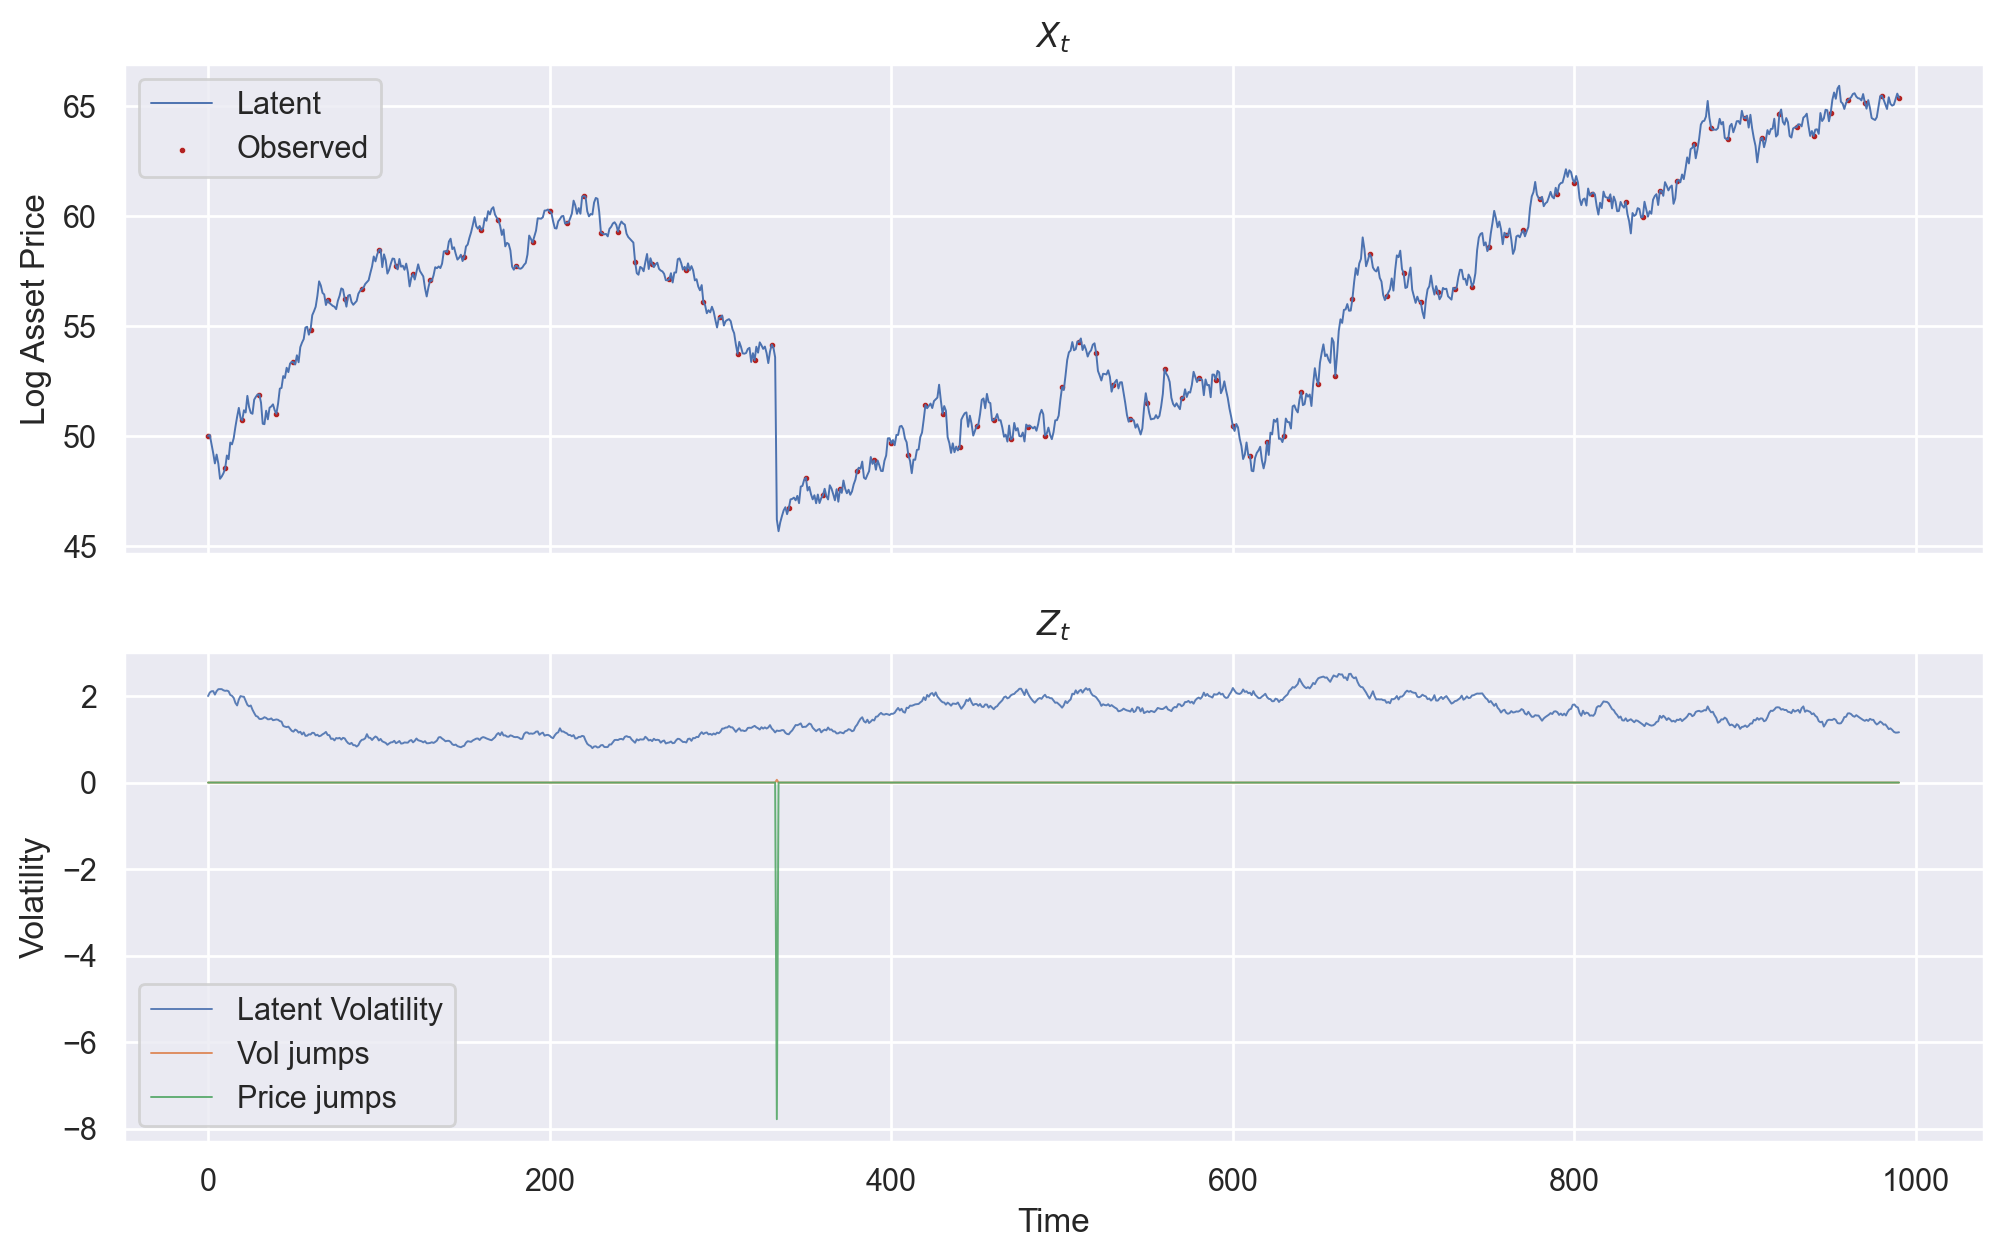

In [142]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(_n_res*n_obs, 1)[(_n_res-1):].squeeze(),
             ax = ax[0], linewidth=0.7,
             label = "Latent")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax[0],
                s=5,
                label="Observed").set(title ="$X_t$");

# plt.plot(y_meas)
sns.lineplot(data= x_state[..., 0].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
             ax = ax[1], alpha = 0.9, linewidth=0.7,
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");
sns.lineplot(data= x_state[..., 2].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
             ax = ax[1], alpha = 0.9, linewidth=0.7,
             label = "Vol jumps")
sns.lineplot(data= x_state[..., 3].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
             ax = ax[1], alpha = 0.9, linewidth=0.7,
             label = "Price jumps");

In [107]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharey = False)
# ax2 = ax.twinx()

# sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
#              ax = ax,
#              label = "Latent")
# sns.scatterplot(x = "Time", y = "Log Asset Price", 
#                 data = point_plot,
#                 color = "firebrick",
#                 ax = ax,
#                 label="Observed").set(title ="$X_t$ and $Z_t$");

# # plt.plot(y_meas)
# with sns.axes_style("whitegrid"):
#     ax2.set_facecolor('white');
#     ax2.grid(False)
#     sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
#                  ax = ax2, color = "green").set(ylabel="Volatility");

## `pfjax` PF

In [108]:
from functools import partial

import pfjax as pf
from pfjax import particle_resamplers as resampler

In [148]:
def neg_loglik(theta, y_meas, model, key, n_particles=500, resample_fn=resampler.resample_multinomial):
    """ negative log-likelihood of PF with continuous resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resample_fn,
        history = False)
    return -ret["loglik"]


def plot_particles (x_state, y_meas, vol_particles, price_particles, title="", plot_res=True):
    n_res = _n_res
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex = True)
    fig.suptitle(title)

    sns.lineplot(data= x_state[..., 1].reshape(n_res*n_obs, 1)[(n_res-1):].squeeze(),
                 ax = ax[0], linewidth = 0.7,
                 label = "Latent")
    sns.scatterplot(x = "Time", y = "Log Asset Price", 
                    data = point_plot,
                    color = "firebrick",
                    ax = ax[0],
                    label="Observed").set(xlabel="Time",title ="$X_t$");

    sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
                 ax = ax[1], linewidth = 0.7,
                 label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility")
    if plot_res:
        for t in range(n_obs-1):
            for s in range(n_res):
                my_x = (t*n_res) + s
                sns.scatterplot(x = my_x, 
                                y=price_particles[t, :, s], 
                                s = 2, alpha = 0.5,
                                color = "green", ax = ax[0]);
                sns.scatterplot(x = my_x, 
                                y=vol_particles[t, :, s], 
                                s = 2, alpha = 0.5,
                                color = "green", ax = ax[1]);
    else:
        for t in range(n_obs-1):
            sns.scatterplot(x = t*n_res, 
                            y=price_particles[t, :, n_res-2], 
                            s = 2, alpha = 0.5,
                            color = "green", ax = ax[0]);
            sns.scatterplot(x = t*n_res, 
                            y=vol_particles[t, :, n_res-2], 
                            s = 2, alpha = 0.5,
                            color = "green", ax = ax[1]);

In [144]:
def jittered_multinomial(key, x_particles_prev, logw, h):
    r"""
    Variant of the resampling function presented in: 
    https://www.tandfonline.com/doi/abs/10.1198/jcgs.2009.07137
    
    They jitter each particle with N(0, h^2 B). However it is not clear how B is selected.
    I have selected the kernel bandwidth here, h, as 1/num_particles
    """
    prob = pf.utils.logw_to_prob(logw)
    n_particles = logw.size
    ancestors = random.choice(key,
                              a=jnp.arange(n_particles),
                              shape=(n_particles,), p=prob)
    jitter = random.normal(key, shape = x_particles_prev.shape) * h
    return {
        "x_particles": x_particles_prev[ancestors, ...] + jitter,
        "ancestors": ancestors
    }

# jax.jit(partial(
#     neg_loglik,
#     y_meas = y_meas_bm,
#     model = bm_model,
#     key=subkey,
#     n_particles=n_particles_multinom,
#     resample_fn = resampler.resample_multinomial))

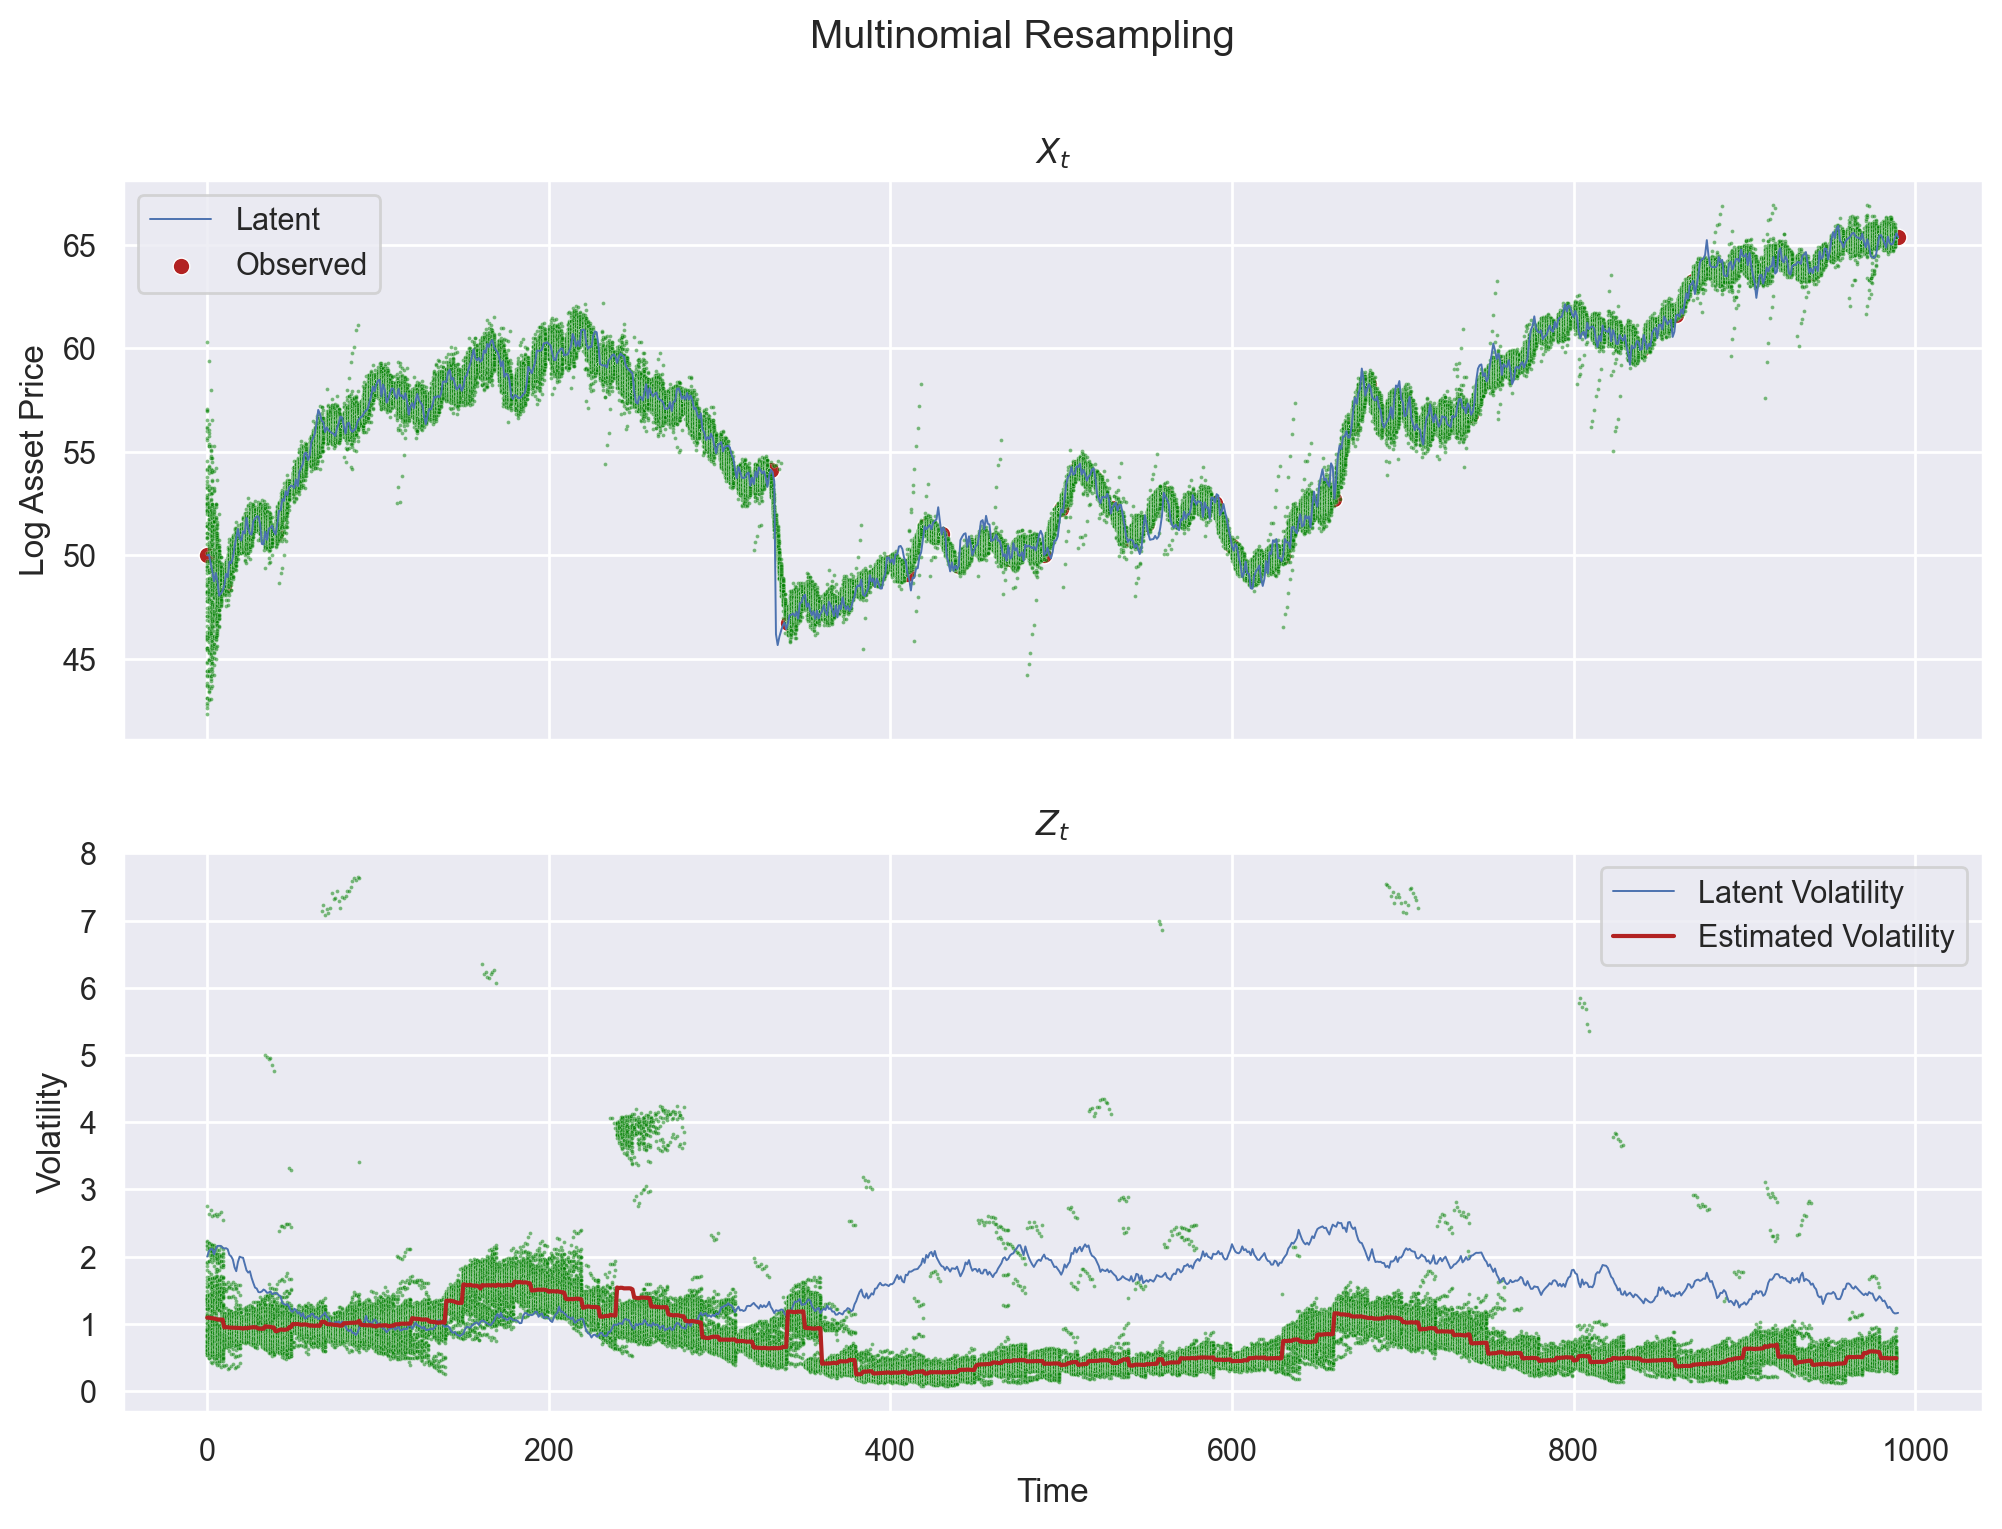

In [145]:
num_particles = 100
resample_jittered_multinomial = partial(
    jittered_multinomial,
    h=1/num_particles
)

multinom_pf = pf.particle_filter(
    theta=theta, 
    model=jdmodel, 
    y_meas=y_meas, 
    n_particles=100, 
    resampler=resample_jittered_multinomial, #resampler.resample_multinomial,
    key=key,
    history = True)

plot_particles(x_state, y_meas, 
               vol_particles=multinom_pf["x_particles"][1:, :, :, 0], 
               price_particles=multinom_pf["x_particles"][1:, :, :, 1],
               title = "Multinomial Resampling")

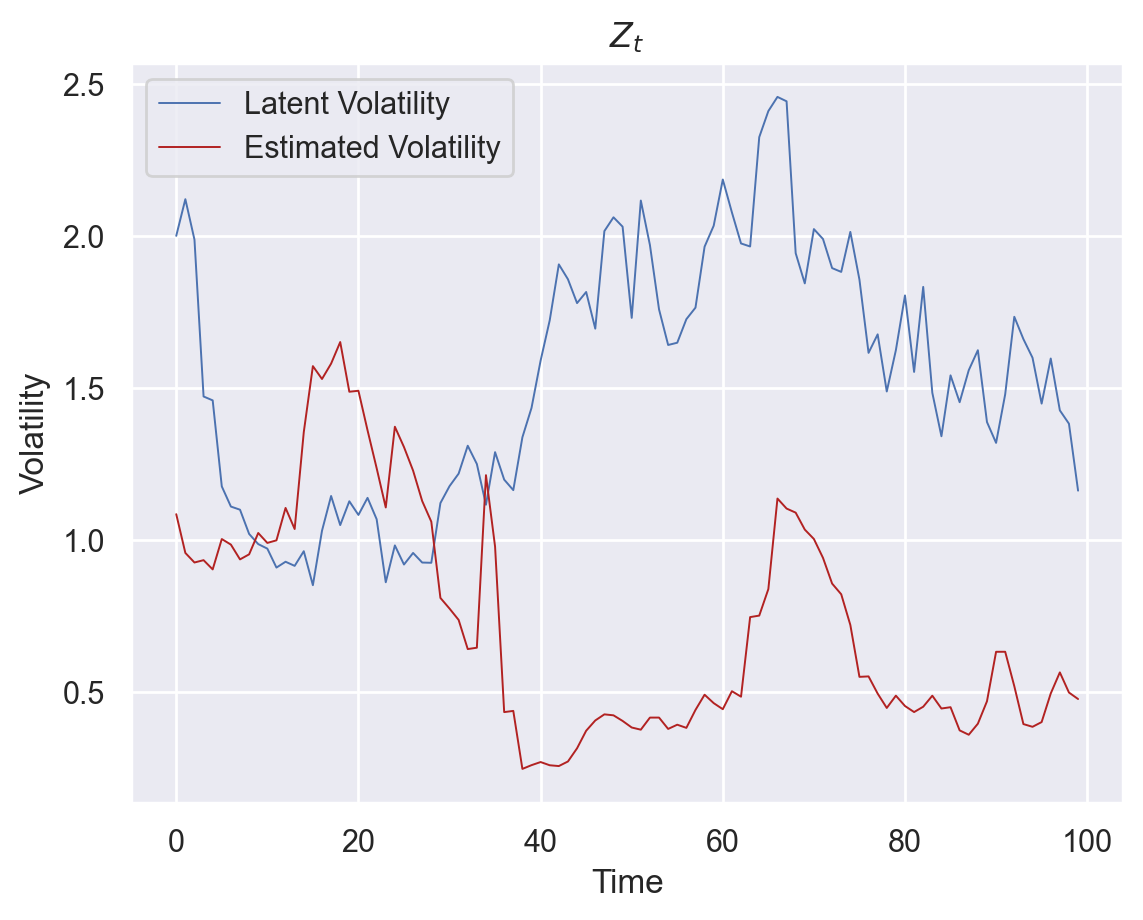

In [158]:
est_vol = jnp.average(multinom_pf["x_particles"][..., -1, 0], axis=1, 
                      weights=pf.utils.logw_to_prob(multinom_pf["logw"]))

sns.lineplot(
#     data=x_state[..., 0].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
    data = x_state[:, -1, 0],
    linewidth = 0.7,
    label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility")
sns.lineplot(data=est_vol, #x=jnp.arange(n_obs)*_n_res,
             color = "firebrick", linewidth = 0.7,
             label = "Estimated Volatility");

In [149]:
multinom_pf["loglik"]

DeviceArray(-531.1452, dtype=float32)

## S&P 500 Index Data

[*********************100%***********************]  1 of 1 completed


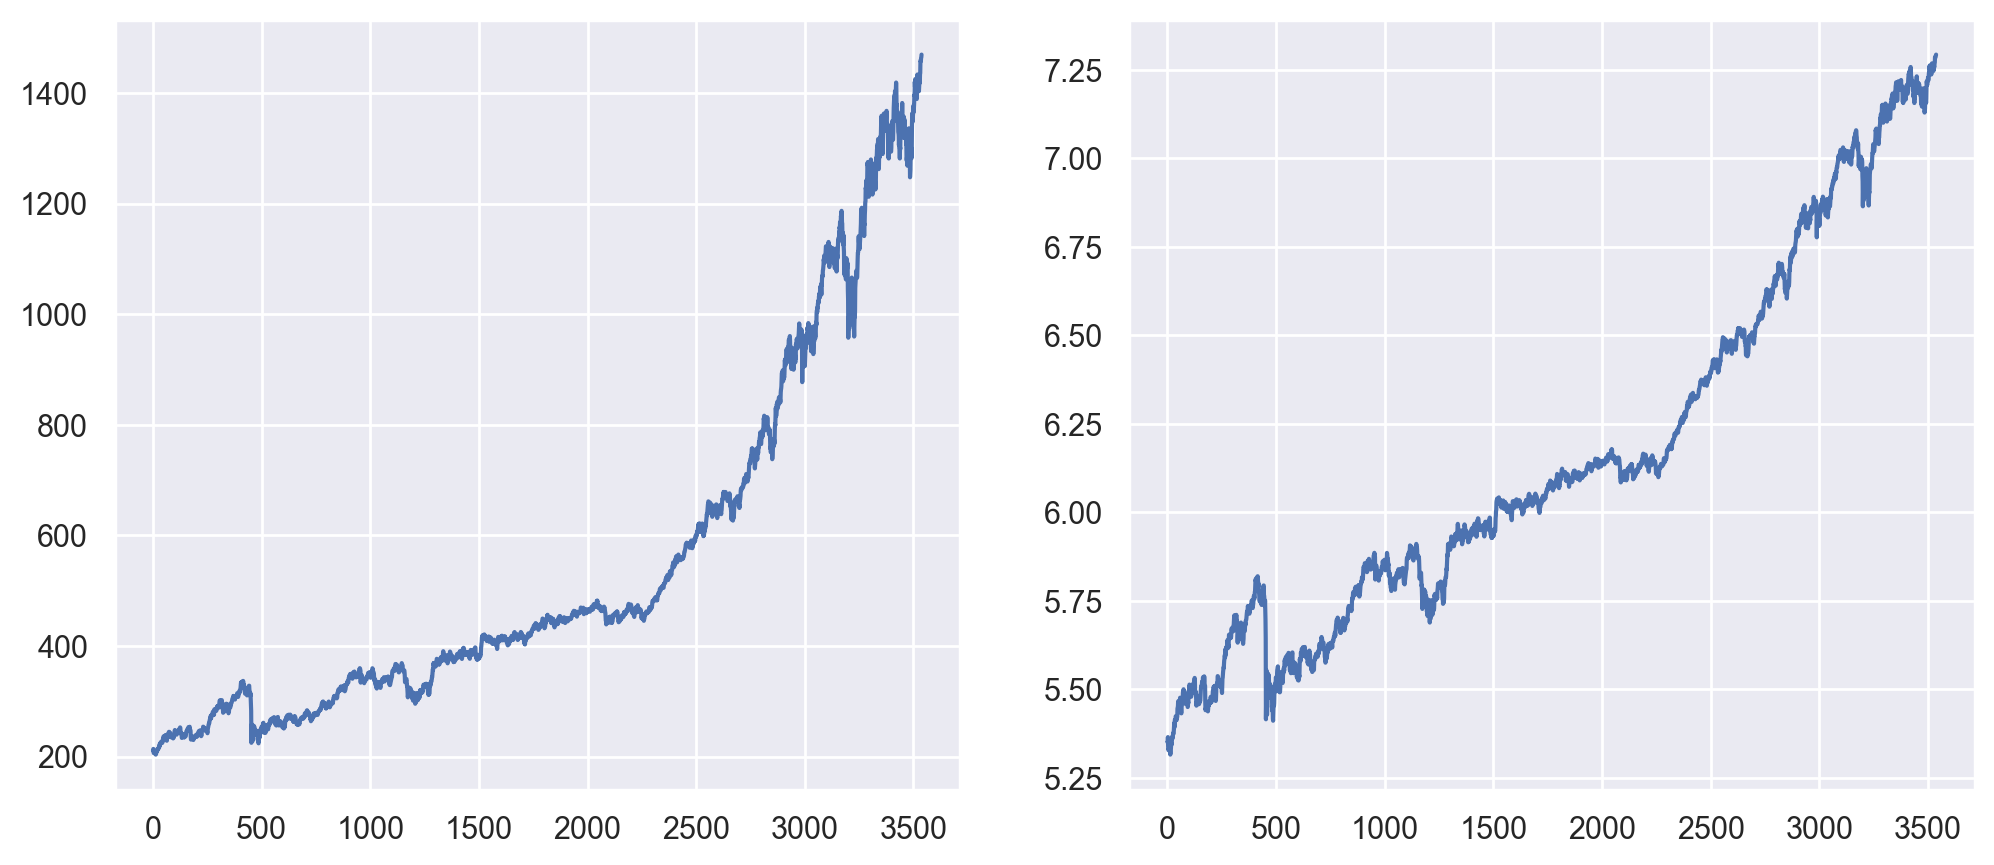

In [114]:
import yfinance as yf

snp_data = yf.download('^GSPC','1986-01-03','2000-01-03')
snp_closing = jnp.array(snp_data["Adj Close"])
snp_log_closing = jnp.log(snp_closing)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex = True)
sns.lineplot(snp_closing, ax = ax[0])
sns.lineplot(snp_log_closing, ax = ax[1]);

In [150]:
num_particles = 100
resample_jittered_multinomial = partial(
    jittered_multinomial,
    h=1/num_particles
)

snp_filtered = pf.particle_filter(
    theta=theta, 
    model=jdmodel, 
    y_meas=snp_log_closing[:200], 
    n_particles=100, 
    resampler=resample_jittered_multinomial, #resampler.resample_multinomial,
    key=key,
    history = True)

In [151]:
snp_filtered["loglik"]

DeviceArray(-1055.6995, dtype=float32)

In [122]:
jnp.sum(snp_filtered["logw"], axis = 1)[171:]

DeviceArray([       nan, -698.28723,        nan, -675.07104, -639.275  ,
                    nan, -764.6688 , -747.253  , -713.34326, -771.2159 ,
             -809.0408 , -796.59436, -781.00867, -825.96484, -767.7646 ,
             -792.09143, -833.2124 , -816.2937 , -795.63605, -831.2629 ,
             -790.66833, -779.1189 , -811.71155, -820.18756, -789.6609 ,
             -751.0142 , -797.0935 , -810.39417, -816.5355 ],            dtype=float32)

In [129]:
snp_filtered["logw"][171, 60]

DeviceArray(nan, dtype=float32)

In [135]:
sum(snp_filtered["x_particles"][..., 0].flatten() < 0)

DeviceArray(0, dtype=int32, weak_type=True)

In [131]:
snp_filtered["x_particles"][171, 59:61, ...]

DeviceArray([[[0.03501428, 5.4545217 , 0.        , 0.        ],
              [0.03711086, 5.455075  , 0.        , 0.        ],
              [0.03546438, 5.5106177 , 0.        , 0.        ],
              [0.03061071, 5.4945636 , 0.        , 0.        ],
              [0.02965414, 5.4541497 , 0.        , 0.        ],
              [0.02198963, 5.5225945 , 0.        , 0.        ],
              [0.02380716, 5.5229516 , 0.        , 0.        ],
              [0.03461136, 5.544615  , 0.        , 0.        ],
              [0.02610927, 5.5336285 , 0.        , 0.        ],
              [0.03339297, 5.5139933 , 0.        , 0.        ]],

             [[       nan,        nan, 0.        , 0.        ],
              [       nan,        nan, 0.        , 0.        ],
              [       nan,        nan, 0.        , 0.        ],
              [       nan,        nan, 0.        , 0.        ],
              [       nan,        nan, 0.        , 0.        ],
              [       nan,        nan,

In [ ]:
jdmodel.state_lpdf(x_curr, x_prev, theta):

In [136]:
x_prev_tmp = jnp.array(
    [[0.03501428, 5.4545217 , 0.        , 0.        ],
      [0.03711086, 5.455075  , 0.        , 0.        ],
      [0.03546438, 5.5106177 , 0.        , 0.        ],
      [0.03061071, 5.4945636 , 0.        , 0.        ],
      [0.02965414, 5.4541497 , 0.        , 0.        ],
      [0.02198963, 5.5225945 , 0.        , 0.        ],
      [0.02380716, 5.5229516 , 0.        , 0.        ],
      [0.03461136, 5.544615  , 0.        , 0.        ],
      [0.02610927, 5.5336285 , 0.        , 0.        ],
      [0.03339297, 5.5139933 , 0.        , 0.        ]]
)

In [137]:
# key, x_prev, y_curr, theta
key, subkey = random.split(key)
jdmodel.pf_step(subkey, 
                x_prev=x_prev_tmp, # snp_filtered["x_particles"][151, 92, ...],
                y_curr=snp_log_closing[171], 
                theta=theta)

(DeviceArray([[0.05175105, 5.5183253 , 0.        , 0.        ],
              [0.05675422, 5.4825435 , 0.        , 0.        ],
              [0.05979046, 5.401873  , 0.        , 0.        ],
              [0.06955304, 5.346331  , 0.        , 0.        ],
              [0.06029379, 5.433699  , 0.        , 0.        ],
              [0.08060987, 5.3804812 , 0.        , 0.        ],
              [0.07774094, 5.544794  , 0.        , 0.        ],
              [0.08475825, 5.7043343 , 0.        , 0.        ],
              [0.10905558, 5.6601152 , 0.        , 0.        ],
              [0.11758272, 5.5139933 , 0.        , 0.        ]],            dtype=float32),
 DeviceArray(-5.279447, dtype=float32))

In [59]:
snp_filtered["logw"][152, :]

DeviceArray([ -6.119053 , -10.220141 ,  -7.702346 ,  -9.283413 ,
              -4.024929 ,  -6.3788033,  -7.5085335,  -5.496562 ,
              -9.375597 ,  -8.211605 ,  -7.0837092,  -9.032669 ,
              -5.322955 ,  -7.220117 ,  -6.583254 ,  -6.5724306,
              -6.232552 ,  -5.135249 ,  -6.9569216,  -5.6169376,
              -6.700398 ,  -8.939936 ,  -6.3562746,  -9.072961 ,
              -4.0482945,  -8.542453 ,  -6.651385 ,  -8.950159 ,
              -6.908579 ,  -8.969686 ,  -6.719498 ,  -9.251718 ,
              -7.9466434,  -8.565153 ,  -8.250633 ,  -5.3914366,
             -10.085391 ,  -6.4012833,  -8.330038 ,  -7.053385 ,
              -9.495857 ,  -6.309107 ,  -8.790225 ,  -8.106022 ,
              -9.91507  ,  -1.9314921,  -5.636742 ,  -7.454824 ,
              -8.169078 ,  -5.2478724,  -3.011836 ,  -5.2705007,
              -5.595225 ,  -8.495052 ,  -6.809285 ,  -7.9298153,
              -8.599714 ,  -9.04341  ,  -6.2720633,  -7.924436 ,
              -7.383358 ,

In [ ]:
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax[0],
                label="Observed").set(xlabel="Time",title ="$X_t$");

sns.lineplot(data= x_state[..., 0].reshape(n_res*n_obs,1)[(n_res-1):].squeeze(),
             ax = ax[1], linewidth = 0.7,
             label = "Latent Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility")
sns.lineplot(data= jnp.mean(vol_particles, axis = 1).reshape(-1),
             ax = ax[1], color = "firebrick",
             label = "Estimated Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");
if plot_res:
    for t in range(n_obs-1):
        for s in range(n_res):
            my_x = (t*n_res) + s
            sns.scatterplot(x = my_x, 
                            y=price_particles[t, :, s], 
                            s = 2, alpha = 0.5,
                            color = "green", ax = ax[0]);
            sns.scatterplot(x = my_x, 
                            y=vol_particles[t, :, s], 
                            s = 2, alpha = 0.5,
                            color = "green", ax = ax[1]);
else:
    for t in range(n_obs-1):
        sns.scatterplot(x = t*n_res, 
                        y=price_particles[t, :, n_res-2], 
                        s = 2, alpha = 0.5,
                        color = "green", ax = ax[0]);
        sns.scatterplot(x = t*n_res, 
                        y=vol_particles[t, :, n_res-2], 
                        s = 2, alpha = 0.5,
                        color = "green", ax = ax[1]);

## Misc

In [ ]:
def tmp_resample_mvn(key, x_particles_prev, logw):
    prob = pf.utils.logw_to_prob(logw)
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    # calculate weighted mean and variance
    x_particles = jnp.transpose(x_particles_prev.reshape((n_particles, -1)))
    mvn_mean = jnp.average(x_particles, axis=1, weights=prob)
    mvn_cov = jnp.atleast_2d(jnp.cov(x_particles, aweights=prob))
    # for numeric stability
    mvn_cov += jnp.diag(jnp.ones(mvn_cov.shape[0]) * 1e-10)
    x_particles = random.multivariate_normal(key,
                                             mean=mvn_mean,
                                             cov=mvn_cov,
                                             shape=(n_particles,))
    return {
        "x_particles": jnp.reshape(x_particles, newshape=p_shape),
        "mvn_mean": mvn_mean,
        "mvn_cov": mvn_cov
    }

In [ ]:
mvn_pf = pf.particle_filter(
    theta=theta, 
    model=jdmodel, 
    y_meas=y_meas, 
    n_particles=100, 
    resampler=resampler.resample_mvn,
    key=key,
    history = True)

plot_particles(x_state, y_meas, 
               vol_particles=mvn_pf["x_particles"][1:, :, :, 0], 
               price_particles=mvn_pf["x_particles"][1:, :, :, 1],
               title = "MVN Resampling")

In [ ]:
d = tmp_resample_mvn(key, mvn_pf["x_particles"][0], mvn_pf["logw"][0])

In [ ]:
print(d["x_particles"][0, ...])

In [ ]:
print(mvn_pf["x_particles"][0, 0, ...])

In [ ]:
# calculate weights: 
jdmodel.state_lpdf(x_curr = d["x_particles"][0, ...], 
                   x_prev=mvn_pf["x_particles"][0, 0, ...],
                   theta=theta)

In [ ]:
mvn_pf["x_particles"][1:3, :, :, 1]

In [ ]:
i = 0
print("covmat eigvals: ", jnp.linalg.eigvals(mvn_pf["resample_out"]["mvn_cov"][i, ...]))
print("covmat diags: ", jnp.diag(mvn_pf["resample_out"]["mvn_cov"][i, ...]) > 0)

print("covmat eigvals: ", jnp.linalg.eigvals(mvn_pf["resample_out"]["mvn_cov"][i, ...]))
print("covmat diags: ", jnp.diag(mvn_pf["resample_out"]["mvn_cov"][i, ...]) > 0)

In [ ]:
gc_pf = pf.particle_filter(
    theta=theta, 
    model=jdmodel, 
    y_meas=y_meas, 
    n_particles=100, 
    resampler=resampler.resample_gaussian_copula,
    key=key,
    history = True)

plot_particles(x_state, y_meas, 
               vol_particles=gc_pf["x_particles"][1:, :, :, 0], 
               price_particles=gc_pf["x_particles"][1:, :, :, 1],
               title = "Gaussian Copula Resampling")